In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
# 경로 설정
full_dir = "/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/sports/user_repr"
sampled_dir = "/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/sports75/user_repr"

In [49]:
user_files = sorted(os.listdir(full_dir))  # ['123.pt', '456.pt', ...]

l2_distances = []
cosine_similarities = []
user_ids = []

for fname in tqdm(user_files):
    full_path = os.path.join(full_dir, fname)
    sampled_path = os.path.join(sampled_dir, fname)

    if not os.path.exists(sampled_path):
        continue  # 샘플링에 없는 유저는 스킵

    full_obj = torch.load(full_path, map_location="cuda:7", weights_only=False)
    sampled_obj = torch.load(sampled_path, map_location="cuda:7", weights_only=False)

    full_vec = full_obj["user_repr"] # torch.Size([1, 50])
    sampled_vec = sampled_obj["user_repr"]

    full_vec = full_vec.squeeze(0)
    sampled_vec = sampled_vec.squeeze(0)

    # L2 distance
    l2 = torch.norm(full_vec - sampled_vec, p=2).item()
    l2_distances.append(l2)

    # Cosine similarity (normalize 후 dim=0으로 정확히)
    full_vec = F.normalize(full_vec, dim=0)
    sampled_vec = F.normalize(sampled_vec, dim=0)
    cos_sim = F.cosine_similarity(full_vec, sampled_vec, dim=0).item()
    cosine_similarities.append(cos_sim)

    user_ids.append(full_obj["user_ids"])


# 통계 요약
print(f"[L2] mean: {np.mean(l2_distances):.4f}, std: {np.std(l2_distances):.4f}")
print(f"[Cosine Sim] mean: {np.mean(cosine_similarities):.4f}, std: {np.std(cosine_similarities):.4f}")

100%|██████████| 512/512 [00:00<00:00, 966.66it/s] 

[L2] mean: 12.6990, std: 0.6700
[Cosine Sim] mean: -0.0765, std: 0.1036


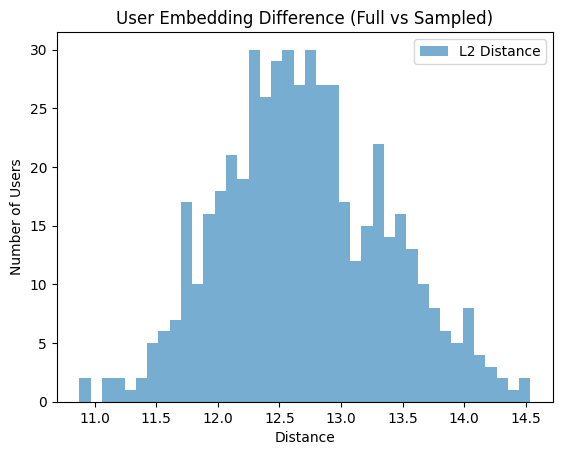

In [50]:
# 히스토그램 시각화
plt.hist(l2_distances, bins=40, alpha=0.6, label="L2 Distance")
plt.xlabel("Distance")
plt.ylabel("Number of Users")
plt.title("User Embedding Difference (Full vs Sampled)")
plt.legend()
plt.show()

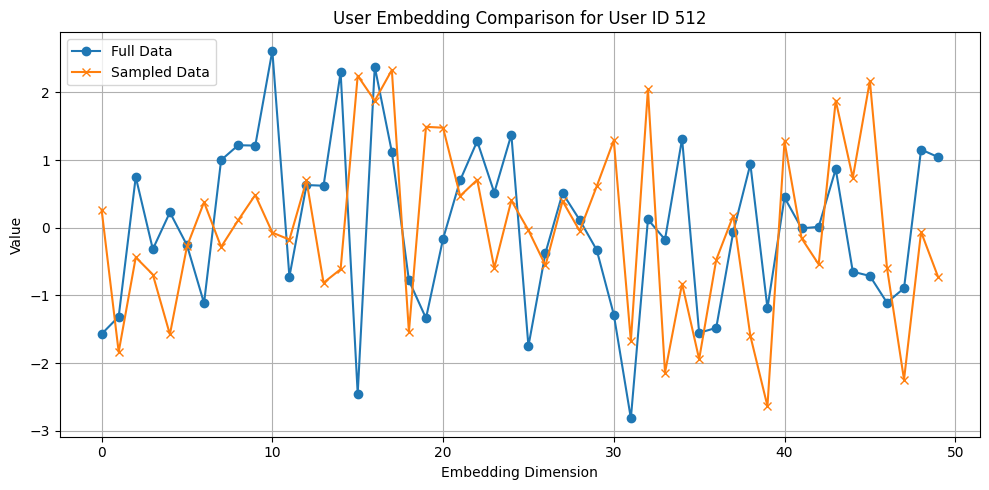

In [ ]:
import torch
import matplotlib.pyplot as plt
import os

user_id = "512"  # 비교할 유저 ID
full_path = os.path.join(full_dir, f"{user_id}.pt")
sampled_path = os.path.join(sampled_dir, f"{user_id}.pt")

full_obj = torch.load(full_path, map_location="cuda:7", weights_only=False)
sampled_obj = torch.load(sampled_path, map_location="cuda:7", weights_only=False)

full_vec = full_obj["user_repr"].squeeze()      # [50]
sampled_vec = sampled_obj["user_repr"].squeeze()  # [50]

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(full_vec.cpu().numpy(), label="Full Data", marker='o')
plt.plot(sampled_vec.cpu().numpy(), label="Sampled Data", marker='x')
plt.title(f"User Embedding Comparison for User ID {user_id}")
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


100%|██████████| 512/512 [00:00<00:00, 1214.62it/s]


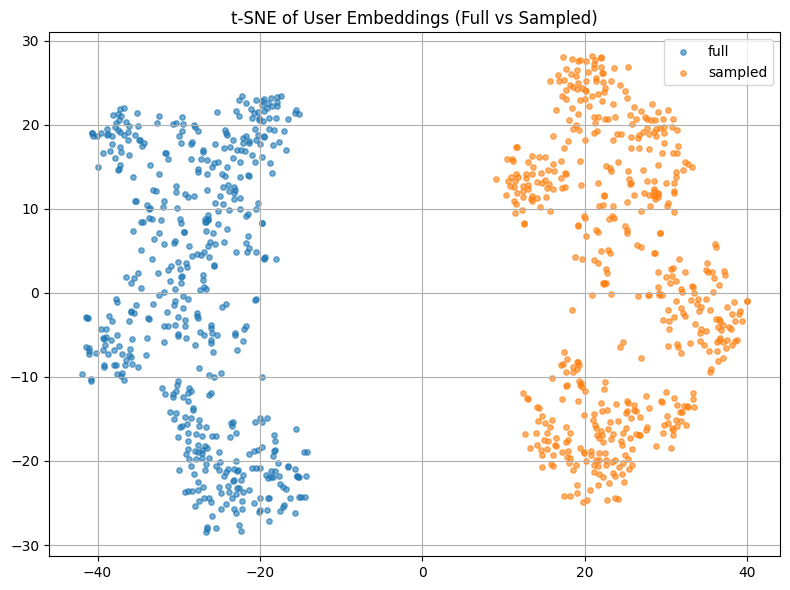

In [14]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE

# 경로 설정
full_dir = "/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/sports/user_repr"
sampled_dir = "/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/sports_sampling/user_repr"

user_files = sorted(os.listdir(full_dir))  # 예: ['123.pt', '456.pt', ...]

full_embeddings = []
sampled_embeddings = []
user_ids = []

for fname in tqdm(user_files):
    full_path = os.path.join(full_dir, fname)
    sampled_path = os.path.join(sampled_dir, fname)

    if not os.path.exists(sampled_path):
        continue

    full_obj = torch.load(full_path, map_location="cuda:7", weights_only=False)
    sampled_obj = torch.load(sampled_path, map_location="cuda:7", weights_only=False)

    full_vec = full_obj["user_repr"].squeeze(0)         # [1, d] -> [d]
    sampled_vec = sampled_obj["user_repr"].squeeze(0)   # [1, d] -> [d]

    full_vec = torch.nn.functional.normalize(full_vec, dim=0)
    sampled_vec = torch.nn.functional.normalize(sampled_vec, dim=0)

    full_embeddings.append(full_vec.cpu().numpy())
    sampled_embeddings.append(sampled_vec.cpu().numpy())
    user_ids.append(fname.split(".")[0])  # 예: "123"

# (2N, d)
all_embeddings = np.vstack([full_embeddings, sampled_embeddings])
labels = ["full"] * len(full_embeddings) + ["sampled"] * len(sampled_embeddings)

# t-SNE로 2D 투영
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(all_embeddings)

# 시각화
plt.figure(figsize=(8, 6))
for label in ["full", "sampled"]:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=label, alpha=0.6, s=15)

plt.title("t-SNE of User Embeddings (Full vs Sampled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


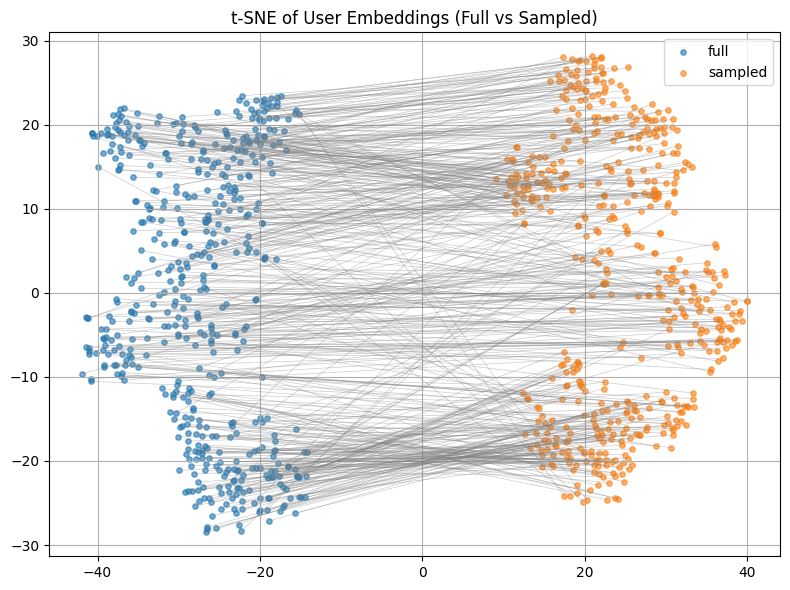

In [15]:
plt.figure(figsize=(8, 6))

# 먼저 scatter
for label in ["full", "sampled"]:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=label, alpha=0.6, s=15)

# 선 연결: 같은 user_id에 대해 full vs sampled 위치를 잇기
num_users = len(user_ids)
for i in range(num_users):
    x_coords = [tsne_result[i, 0], tsne_result[i + num_users, 0]]  # full, sampled
    y_coords = [tsne_result[i, 1], tsne_result[i + num_users, 1]]
    plt.plot(x_coords, y_coords, color="gray", alpha=0.4, linewidth=0.5)

plt.title("t-SNE of User Embeddings (Full vs Sampled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


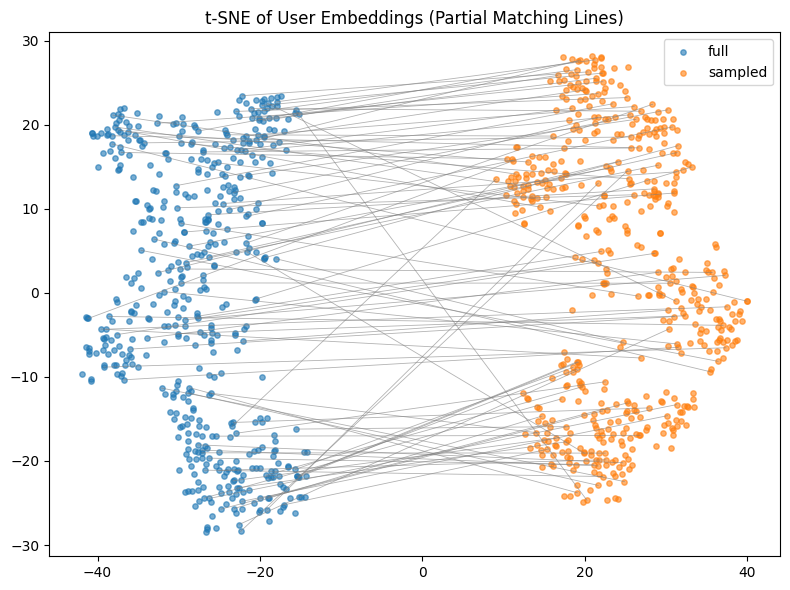

In [20]:
import random

plt.figure(figsize=(8, 6))

# 전체 scatter (full + sampled)
for label in ["full", "sampled"]:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=label, alpha=0.6, s=15)

# 선 연결: 일부 유저만
num_users = len(user_ids)
max_lines = 100  # 연결할 유저 수 제한

sampled_indices = random.sample(range(num_users), min(max_lines, num_users))
for i in sampled_indices:
    x_coords = [tsne_result[i, 0], tsne_result[i + num_users, 0]]  # full, sampled
    y_coords = [tsne_result[i, 1], tsne_result[i + num_users, 1]]
    plt.plot(x_coords, y_coords, color="gray", alpha=0.6, linewidth=0.6)

plt.title("t-SNE of User Embeddings (Partial Matching Lines)")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()


Procrustes disparity: 0.4849


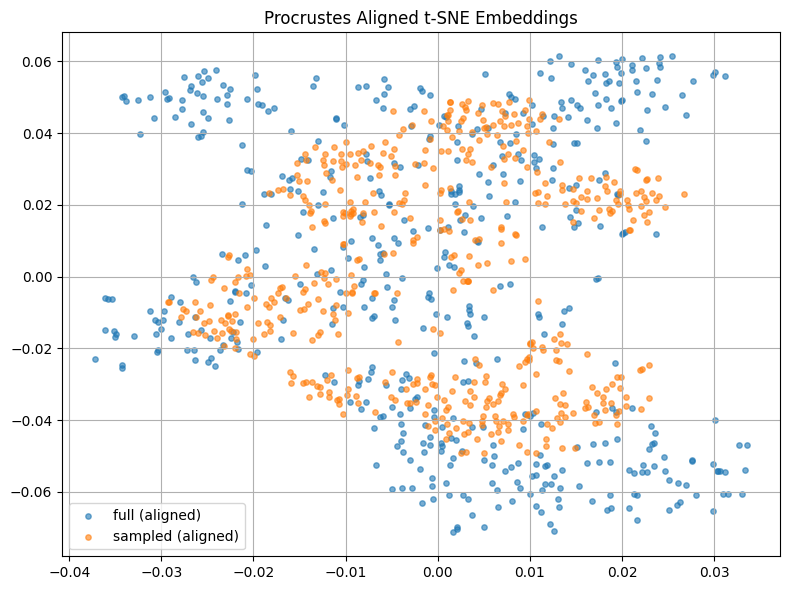

In [24]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE
from scipy.spatial import procrustes

# full / sampled 분리
num_users = len(user_ids)
full_coords = tsne_result[:num_users]
sampled_coords = tsne_result[num_users:]

# ✅ Procrustes 정렬 수행
mtx1, mtx2, disparity = procrustes(full_coords, sampled_coords)
print(f"Procrustes disparity: {disparity:.4f}")

# ✅ Procrustes 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(mtx1[:, 0], mtx1[:, 1], label='full (aligned)', alpha=0.6, s=15)
plt.scatter(mtx2[:, 0], mtx2[:, 1], label='sampled (aligned)', alpha=0.6, s=15)
plt.legend()
plt.grid(True)
plt.title("Procrustes Aligned t-SNE Embeddings")
plt.tight_layout()
plt.show()


In [28]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr, pearsonr

# full_embeddings, sampled_embeddings: [N, d] numpy array 라고 가정

# 1. 각 임베딩에 대해 cosine distance matrix 계산
dist_full = squareform(pdist(full_embeddings, metric="cosine"))      # [N, N]
dist_sampled = squareform(pdist(sampled_embeddings, metric="cosine"))  # [N, N]

# 2. upper triangular part만 추출 (중복 제거, 대각 제외)
triu_indices = np.triu_indices_from(dist_full, k=1)
vec_full = dist_full[triu_indices]
vecrmfj_sampled = dist_sampled[triu_indices]

# 3. 상관계수 계산
spearman_r, spearman_p = spearmanr(vec_full, vecrmfj_sampled)
pearson_r, pearson_p = pearsonr(vec_full, vecrmfj_sampled)

# 결과 출력
print(f"Spearman correlation: r = {spearman_r:.4f}, p = {spearman_p:.4g}")
print(f"Pearson correlation : r = {pearson_r:.4f}, p = {pearson_p:.4g}")

Spearman correlation: r = 0.6812, p = 0
Pearson correlation : r = 0.6857, p = 0


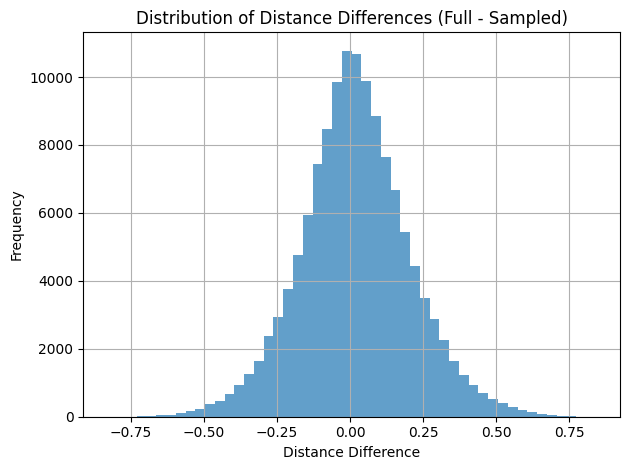

In [29]:
import matplotlib.pyplot as plt

plt.hist(vec_full - vecrmfj_sampled, bins=50, alpha=0.7)
plt.title("Distribution of Distance Differences (Full - Sampled)")
plt.xlabel("Distance Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
import numpy as np

diff = vec_full - vecrmfj_sampled
mean_diff = np.mean(diff)
std_diff = np.std(diff)
max_diff = np.max(np.abs(diff))

print(f"Mean diff      : {mean_diff:.4f}")
print(f"Std of diff    : {std_diff:.4f}")
print(f"Max |diff|     : {max_diff:.4f}")
print(f"Proportion |diff| < 0.2: {(np.mean(np.abs(diff) < 0.2)):.2%}")


Mean diff      : 0.0186
Std of diff    : 0.1879
Max |diff|     : 0.8410
Proportion |diff| < 0.2: 73.50%


## 75%

100%|██████████| 512/512 [00:00<00:00, 614.89it/s]


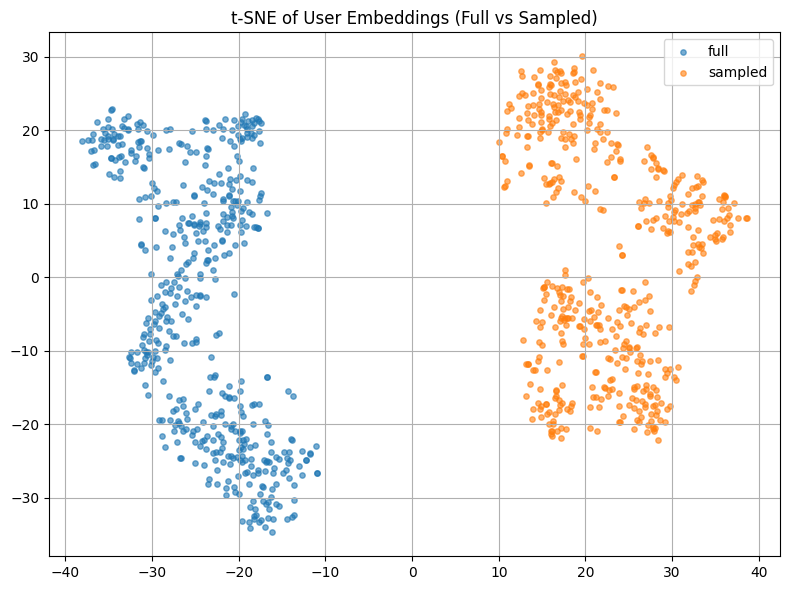

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE

# 경로 설정
full_dir = "/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/pos_preprocess/sports75/user_repr"
dir_75 = "/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/sports75/user_repr"
dir_50 = "/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/sports/user_repr"
dir_random = 

user_files = sorted(os.listdir(full_dir))  # 예: ['123.pt', '456.pt', ...]

full_embeddings = []
sampled_embeddings = []
user_ids = []

for fname in tqdm(user_files):
    full_path = os.path.join(full_dir, fname)
    sampled_path = os.path.join(sampled_dir, fname)

    if not os.path.exists(sampled_path):
        continue

    full_obj = torch.load(full_path, map_location="cuda:7", weights_only=False)
    sampled_obj = torch.load(sampled_path, map_location="cuda:7", weights_only=False)

    full_vec = full_obj["user_repr"].squeeze(0)         # [1, d] -> [d]
    sampled_vec = sampled_obj["user_repr"].squeeze(0)   # [1, d] -> [d]

    full_vec = torch.nn.functional.normalize(full_vec, dim=0)
    sampled_vec = torch.nn.functional.normalize(sampled_vec, dim=0)

    full_embeddings.append(full_vec.cpu().numpy())
    sampled_embeddings.append(sampled_vec.cpu().numpy())
    user_ids.append(fname.split(".")[0])  # 예: "123"

# (2N, d)
all_embeddings = np.vstack([full_embeddings, sampled_embeddings])
labels = ["full"] * len(full_embeddings) + ["sampled"] * len(sampled_embeddings)

# t-SNE로 2D 투영
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(all_embeddings)

# 시각화
plt.figure(figsize=(8, 6))
for label in ["full", "sampled"]:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=label, alpha=0.6, s=15)

plt.title("t-SNE of User Embeddings (Full vs Sampled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


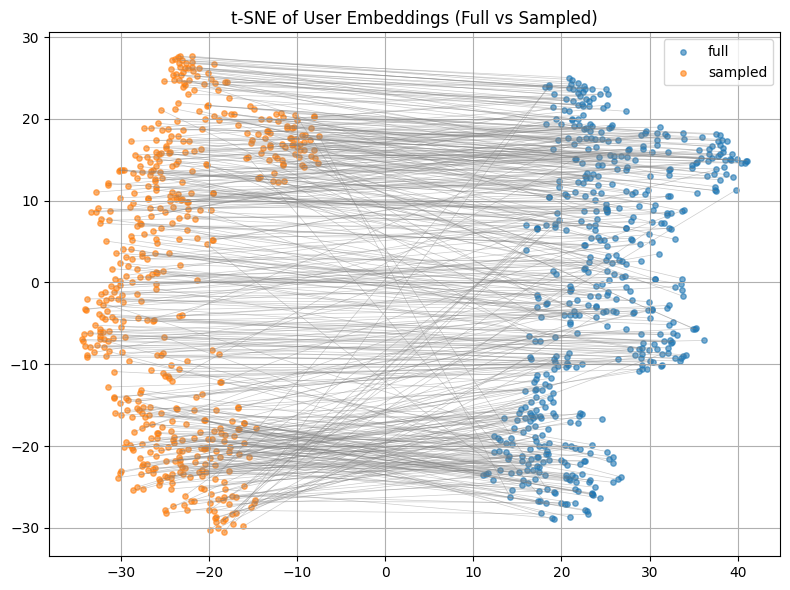

In [2]:
plt.figure(figsize=(8, 6))

# 먼저 scatter
for label in ["full", "sampled"]:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=label, alpha=0.6, s=15)

# 선 연결: 같은 user_id에 대해 full vs sampled 위치를 잇기
num_users = len(user_ids)
for i in range(num_users):
    x_coords = [tsne_result[i, 0], tsne_result[i + num_users, 0]]  # full, sampled
    y_coords = [tsne_result[i, 1], tsne_result[i + num_users, 1]]
    plt.plot(x_coords, y_coords, color="gray", alpha=0.4, linewidth=0.5)

plt.title("t-SNE of User Embeddings (Full vs Sampled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


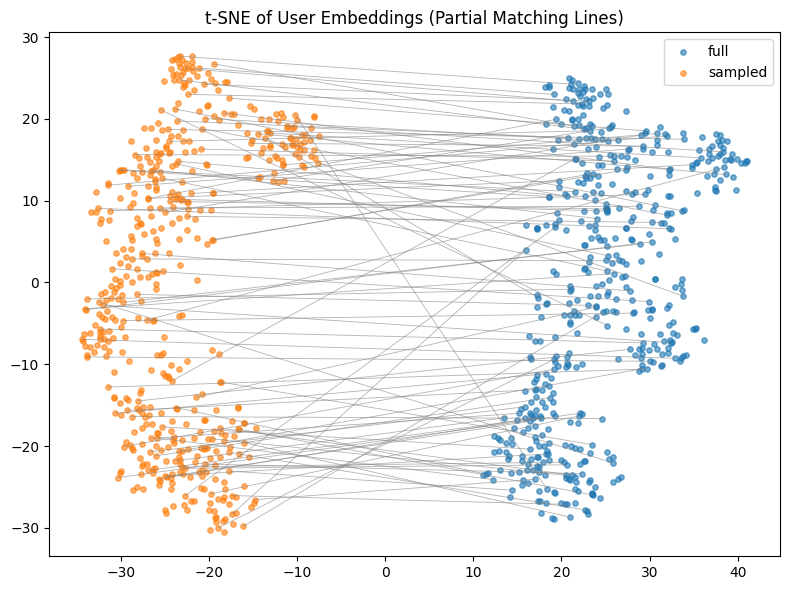

In [3]:
import random

plt.figure(figsize=(8, 6))

# 전체 scatter (full + sampled)
for label in ["full", "sampled"]:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=label, alpha=0.6, s=15)

# 선 연결: 일부 유저만
num_users = len(user_ids)
max_lines = 100  # 연결할 유저 수 제한

sampled_indices = random.sample(range(num_users), min(max_lines, num_users))
for i in sampled_indices:
    x_coords = [tsne_result[i, 0], tsne_result[i + num_users, 0]]  # full, sampled
    y_coords = [tsne_result[i, 1], tsne_result[i + num_users, 1]]
    plt.plot(x_coords, y_coords, color="gray", alpha=0.6, linewidth=0.6)

plt.title("t-SNE of User Embeddings (Partial Matching Lines)")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()


Procrustes disparity: 0.4247


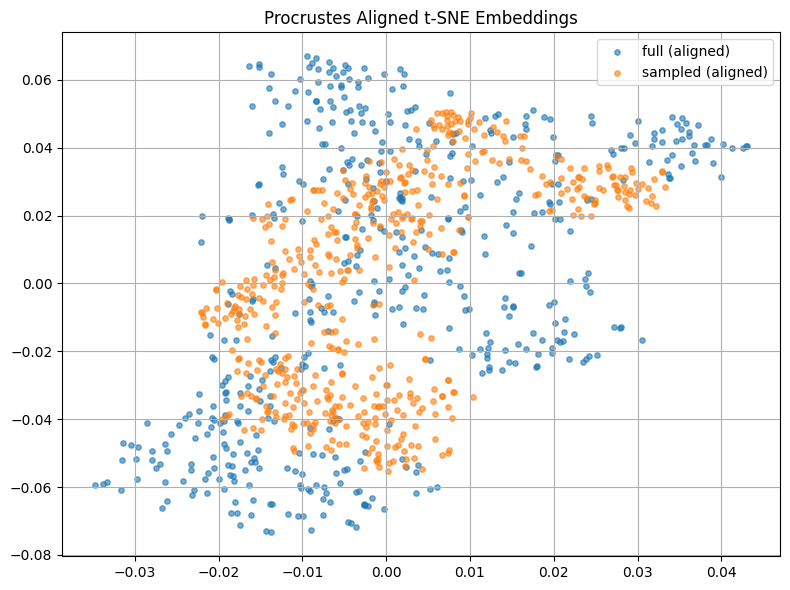

In [4]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE
from scipy.spatial import procrustes

# full / sampled 분리
num_users = len(user_ids)
full_coords = tsne_result[:num_users]
sampled_coords = tsne_result[num_users:]

# ✅ Procrustes 정렬 수행
mtx1, mtx2, disparity = procrustes(full_coords, sampled_coords)
print(f"Procrustes disparity: {disparity:.4f}")

# ✅ Procrustes 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(mtx1[:, 0], mtx1[:, 1], label='full (aligned)', alpha=0.6, s=15)
plt.scatter(mtx2[:, 0], mtx2[:, 1], label='sampled (aligned)', alpha=0.6, s=15)
plt.legend()
plt.grid(True)
plt.title("Procrustes Aligned t-SNE Embeddings")
plt.tight_layout()
plt.show()


In [9]:
len(full_embeddings)
full_embeddings[0].shape

(50,)

In [19]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr, pearsonr

# full_embeddings, sampled_embeddings: [N, d] numpy array 라고 가정

# 1. 각 임베딩에 대해 cosine distance matrix 계산
dist_full = squareform(pdist(full_embeddings, metric="cosine"))      # [N, N]
dist_sampled = squareform(pdist(sampled_embeddings, metric="cosine"))  # [N, N]

# 2. upper triangular part만 추출 (중복 제거, 대각 제외)
triu_indices = np.triu_indices_from(dist_full, k=1)
vec_full = dist_full[triu_indices]
vecrmfj_sampled = dist_sampled[triu_indices]

# 3. 상관계수 계산
spearman_r, spearman_p = spearmanr(vec_full, vecrmfj_sampled)
pearson_r, pearson_p = pearsonr(vec_full, vecrmfj_sampled)

# 결과 출력
print(f"Spearman correlation: r = {spearman_r:.4f}, p = {spearman_p:.4g}")
print(f"Pearson correlation : r = {pearson_r:.4f}, p = {pearson_p:.4g}")

Spearman correlation: r = 0.6879, p = 0
Pearson correlation : r = 0.6951, p = 0


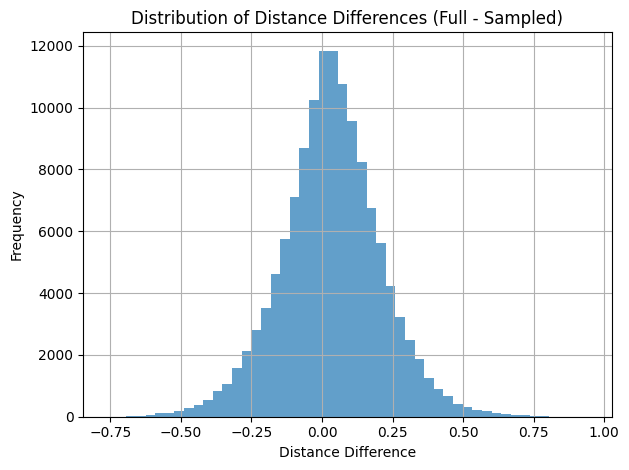

In [20]:
import matplotlib.pyplot as plt

plt.hist(vec_full - vecrmfj_sampled, bins=50, alpha=0.7)
plt.title("Distribution of Distance Differences (Full - Sampled)")
plt.xlabel("Distance Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
import numpy as np

diff = vec_full - vecrmfj_sampled
mean_diff = np.mean(diff)
std_diff = np.std(diff)
max_diff = np.max(np.abs(diff))

print(f"Mean diff      : {mean_diff:.4f}")
print(f"Std of diff    : {std_diff:.4f}")
print(f"Max |diff|     : {max_diff:.4f}")
print(f"Proportion |diff| < 0.2: {(np.mean(np.abs(diff) < 0.2)):.2%}")


Mean diff      : 0.0325
Std of diff    : 0.1772
Max |diff|     : 0.9413
Proportion |diff| < 0.2: 75.50%


In [1]:
import torch

feat = torch.load("/root/mlp_multi/sports/img_features/1881509818.pth", map_location="cpu", weights_only=False)
# 필요하면 GPU로: feat = feat.to("cuda:0")

print(feat)

tensor([ 0.1777,  0.6016, -0.1348,  ...,  0.4883, -0.4043,  0.8125],
       dtype=torch.bfloat16)
